# Графики

In [2]:
import os.path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
imNum = 1
impath = 'trash_img'
#switching latex fonts
plt.rcParams.update({
    "text.usetex" : True,
    "font.family" : "serif",
    "font.serif" : "Computer Modern",
    "text.latex.preamble" : r'\usepackage{amsmath} \usepackage{mathtext} \usepackage[english, russian]{babel}'
})
plt.rcParams.update({
    "figure.figsize": (12, 9),
    'figure.dpi': 200,
    "xtick.minor.visible": True,
    "ytick.minor.visible": True
})

# необходимые функции

def err_pres_formatter(value, error):
    """Rounds value and it's error according to scientific conventions"""
    first_digit = (np.array(error/10**np.floor(np.log10(error)), dtype="int"))
    first_digit_position = np.array(np.floor(np.log10(error)), dtype="int")
    ndigits = 1
    if first_digit == 1:
        ndigits += 1
    power = np.log10(abs(value))
    if abs(power//3) >= 1:
        power = 3*int(power//3)
        value /= 10**power
        error /= 10**power
        digit_number = -first_digit_position + ndigits+power-1
        if digit_number <= 0:
            return f"({round(int(value), digit_number)} \u00B1 {round(int(error), digit_number)})$\cdot 10^{{{power}}}$"
        return f"({round(value, digit_number)} \u00B1 {round(error, digit_number)})$\cdot 10^{{{power}}}$"
    digit_number = -first_digit_position + ndigits-1
    if digit_number <= 0:
        return f"{round(int(value), digit_number)} \u00B1 {round(int(error), digit_number)}"
    return f"{round(value, digit_number)} \u00B1 {round(error, digit_number)}"


def lower_upper_limits(domain, fun, popt, pcov, nsigma=1):
    '''Вычисляет минимальные и максимальные значения функции 
    при заданных парамерах и стандартных отклонениях
    в пределах nsigma*стандартное отклонение
    Возвращает:
    minA :(np.array) - массив минимальных значений
    maxA :(np.array) - массив максимальных значений'''
    err = np.sqrt(np.diag(pcov))
    corr = pcov /np.expand_dims(err, 1) / np.expand_dims(err, 0)
    deviations = np.eye(popt.size)*np.expand_dims(err, 1)  
    df = np.expand_dims(fun(domain, *popt), 1) - fun(np.expand_dims(domain, 1), *(np.expand_dims(popt, 1)+np.eye(popt.size)*np.expand_dims(err, 1)))
    dfmatrixes = np.expand_dims(df, 1)*np.expand_dims(df, 2) * np.expand_dims(corr, 0)
    sigm_f = np.sqrt(np.sum(dfmatrixes, axis=(1, 2)))
    return (fun(domain, *popt)-nsigma*sigm_f, fun(domain, *popt)+nsigma*sigm_f)

In [2]:
#ВВод данных
df = pd.read_excel("measurements.ods", engine="odf")
x = df.iloc[:, 0].dropna()
y = df.iloc[:, 1].dropna()
xerr = 0.1
yerr = 1

In [3]:
df.iloc[:, 0].dropna()

0     18.45
1     18.50
2     18.55
3     18.60
4     18.65
5     18.70
6     18.75
7     18.80
8     18.85
9     18.90
10    18.95
11    19.00
Name: R, om, dtype: float64

In [32]:
#xi square approximation with Y-errors
# пользовательские параметры. Переменные x, y, xerr, yerr дожны содержать данные
''' также необходимо изменить
название осей с размерностями, 
название графика, 
название функции ,
набор параметров с размерностями через запятую '''
visApproxError = True   # рисовать ли область ошибки аппроксимации
par_names_str = r'''
$T_0$, c
$T_1$, c
$\Delta T_{max}$, c
'''
# b, $\Omega$
# function to approximate
fun_name = r"$f(x) = \frac{dR}{dt}t + b$"
fun_name = r"$f(t) = T_1 + \Delta T_{max} \cdot (1-e^{-t/T_0})$"
def f(t, T_0, T_1, dT):
    return T_1 + dT * (1-np.exp(-t/T_0))

# конец пользовательских параметров

from scipy.optimize import curve_fit


In [ ]:
df = pd.read_excel("measurements.ods", engine="odf")
N = 4 # номер измерения
size = 170
x = df.iloc[:, 5*N+1].dropna()[:size]
y = df.iloc[:, 5*N+0].dropna()[:size]
xerr = np.ones_like(x)*1
yerr = np.ones_like(x)*0.002

popt, pcov = curve_fit(f, x[8:], y[8:], sigma=yerr[8:], absolute_sigma=True)
err = np.sqrt(np.diag(pcov))
for v, er in zip(popt, err):
    print(v,'+-',er)

approx_label = f"аппроксимация функцией {fun_name}"
par_names = [x.split(', ') for x in par_names_str.strip().split("\n")]
for i in range(len(par_names)):
    name, units = par_names[i]
    tup = err_pres_formatter(popt[i], err[i])
    approx_label += f"\n{name} = {err_pres_formatter(popt[i], err[i])} {units}"

plt.errorbar(x, y, fmt="o", xerr=xerr, yerr=yerr, label="экспериментальные данные", capsize=4, ms=6)
teorPoints = 50     
intent = 0.05   # отступ по бокам от обласи экспериментальных данных
a, b = x.min(), x.max()
X = np.linspace(a-(b-a)*intent, b+(b-a)*intent, num=teorPoints)
plt.plot(X, f(X, *popt), 'r', label=approx_label)
if visApproxError:
    nsigma = 2
    minA, maxA = lower_upper_limits(X, f, popt, pcov, nsigma=nsigma)
    plt.fill_between(X, minA, maxA, alpha=0.4, label=f"облсть {nsigma} $\sigma$ ошибки")

plt.grid(True)
plt.xlabel(r"$t$, c")
plt.ylabel(r"$R$, $\Omega$")
plt.title(r"$R(t)$")
plt.legend()

plt.savefig(f"{impath}{imNum}.png", dpi=300)
imNum+=1

-150.0


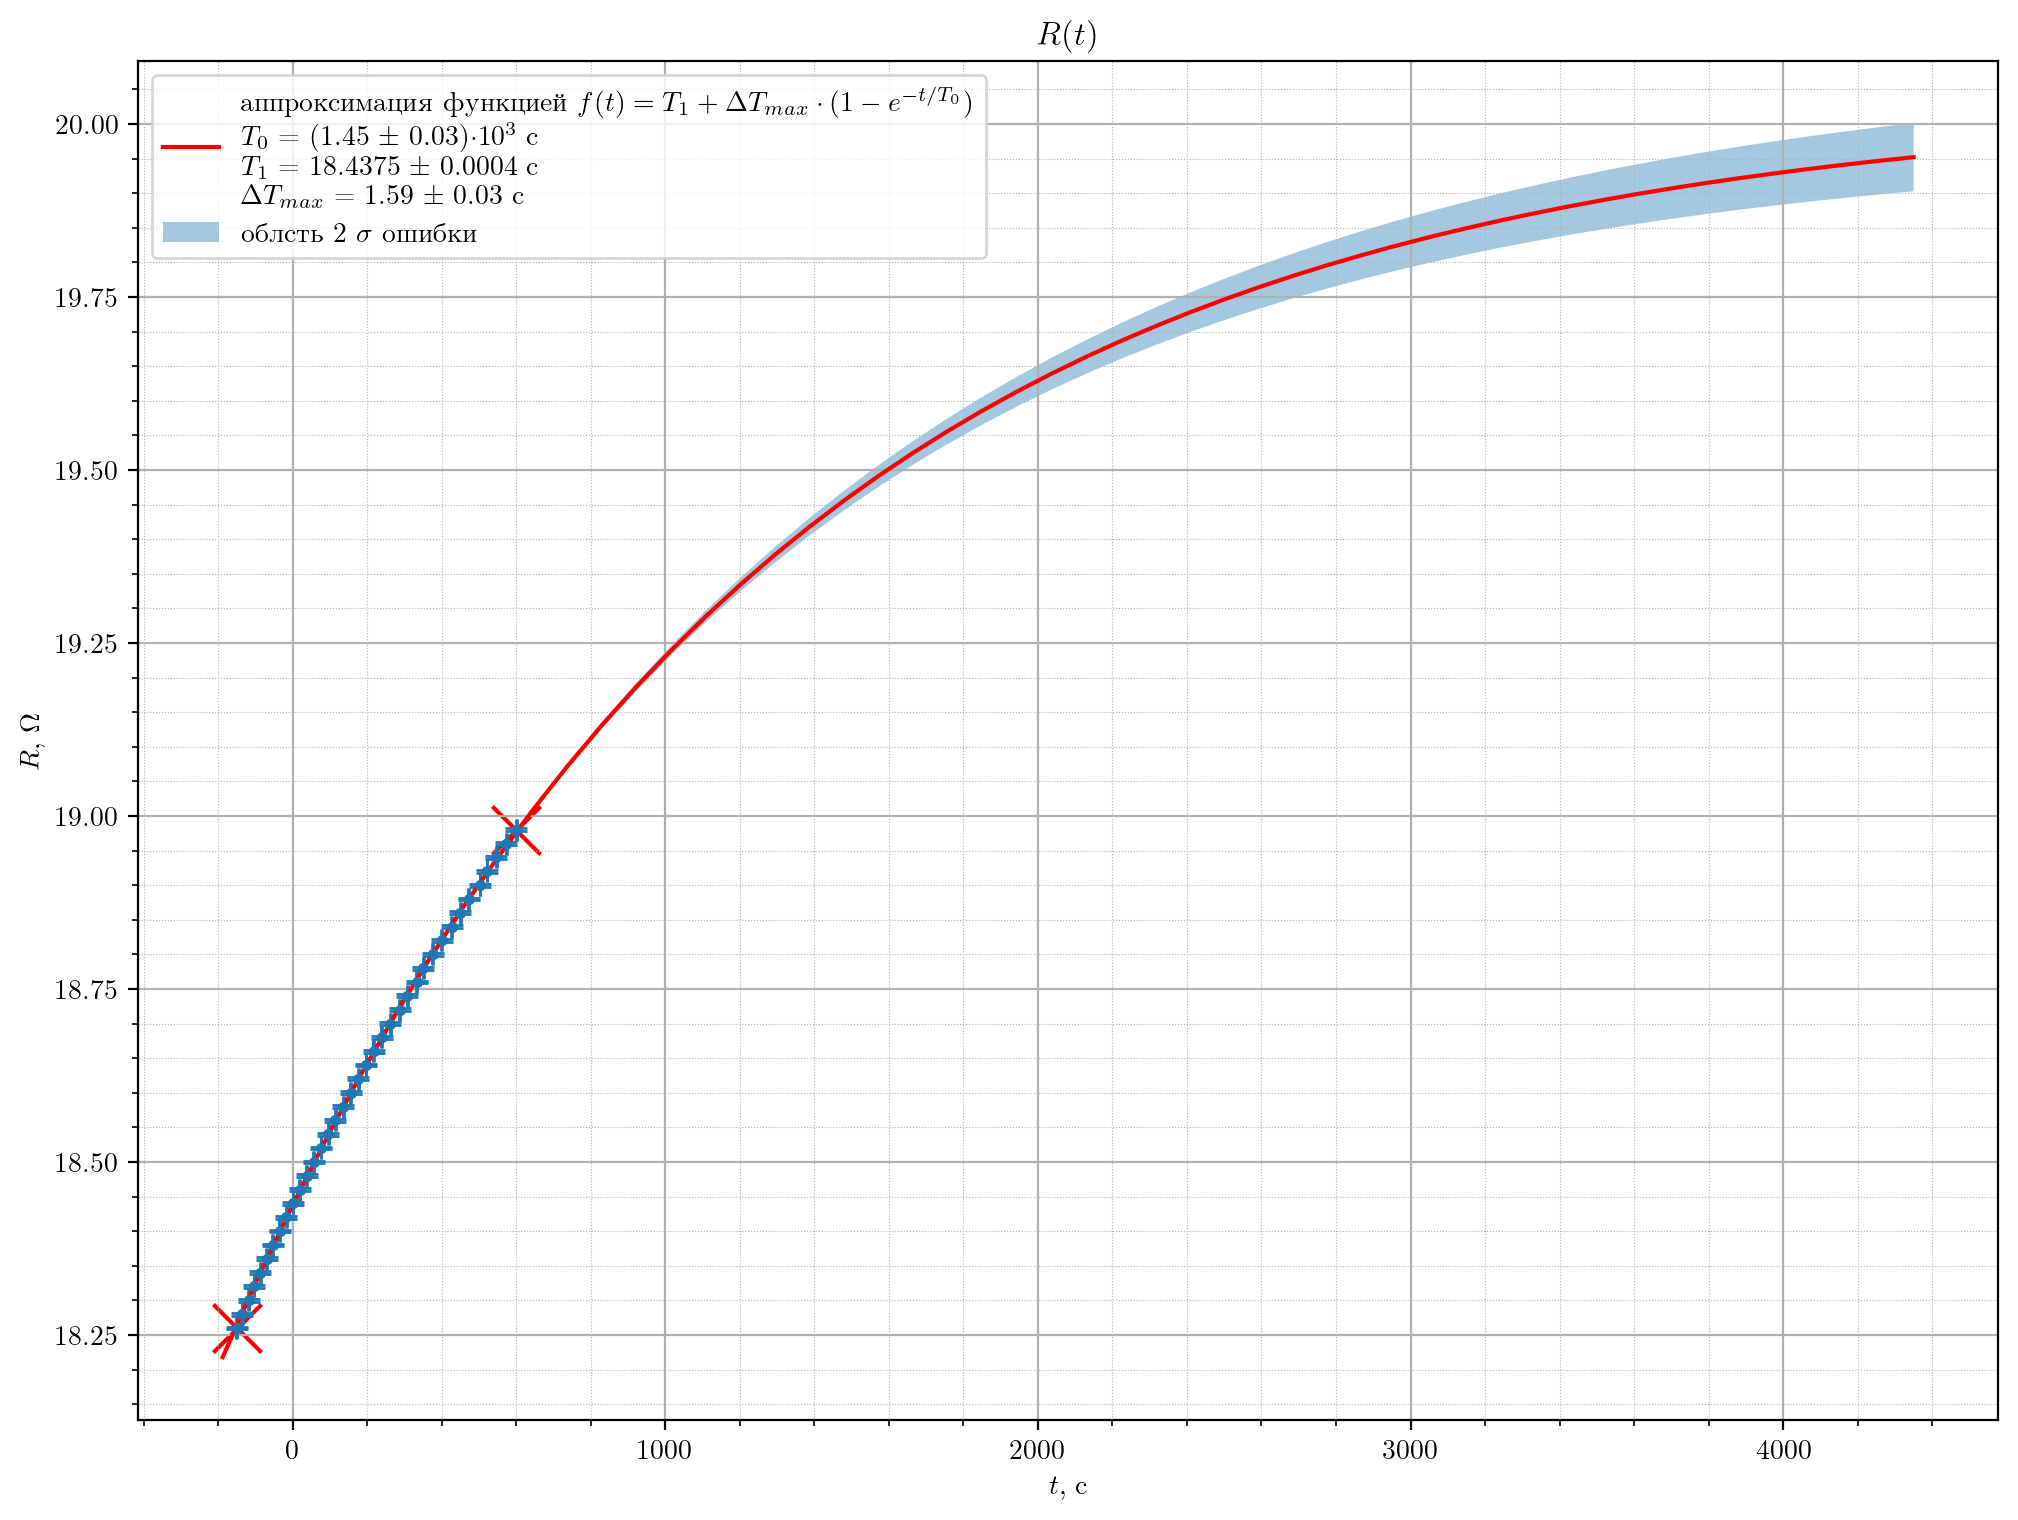

In [37]:
#Несколько графиков на одном холсте
df = pd.read_excel("measurements.ods", engine="odf")
def make_graph(N, xshift, begini=None, endi=None):
    size = 170
    x = df.iloc[:, 5*N+1].dropna()[:size] + xshift
    y = df.iloc[:, 5*N+0].dropna()[:size]
    label = df.iloc[:, 5*N+4].name
    xerr = np.ones_like(x)*1
    yerr = np.ones_like(x)*0.002

    popt, pcov = curve_fit(f, x[begini:endi], y[begini:endi], sigma=yerr[begini:endi], absolute_sigma=True, p0=[5000, 18.5, 300])
    if begini is not None:
        print(x[begini])
        plt.scatter(x[begini], y[begini], s=300, c='red', marker='x')
    else:
        plt.scatter(x[0], y[0], s=300, c='red', marker='x')
    if endi is not None:
        print(x[len(x) + endi-1])
        plt.scatter(x[len(x) + endi-1], y[len(x) + endi-1], s=300, c='red', marker='x')
    else:
        plt.scatter(x[len(x) + -1], y[len(x) + -1], s=300, c='red', marker='x')
    err = np.sqrt(np.diag(pcov))
    # for v, er in zip(popt, err):
    #     print(v,'+-',er)

    approx_label = f"аппроксимация функцией {fun_name}"
    par_names = [x.split(', ') for x in par_names_str.strip().split("\n")]
    for i in range(len(par_names)):
        name, units = par_names[i]
        approx_label += f"\n{name} = {err_pres_formatter(popt[i], err[i])} {units}"

    plt.errorbar(x, y, fmt="o", xerr=xerr, yerr=yerr, label=label, capsize=4, ms=3)
    teorPoints = 50     
    intent = 0.05   # отступ по бокам от обласи экспериментальных данных
    a, b = x.min(), x.max()
    X = np.linspace(a-(b-a)*intent, b+(b-a)*intent*100, num=teorPoints)
    plt.plot(X, f(X, *popt), 'r', label=approx_label)
    if visApproxError:
        nsigma = 2
        minA, maxA = lower_upper_limits(X, f, popt, pcov, nsigma=nsigma)
        plt.fill_between(X, minA, maxA, alpha=0.4, label=f"облсть {nsigma} $\sigma$ ошибки")

# make_graph(0)
# make_graph(1, 0, begini=5)
# make_graph(2, 100, begini=5, endi=-6)
# make_graph(3, 50, begini=6, endi=-4)
make_graph(4, -150, begini=0)

plt.grid(True, which='minor', linewidth=0.4, linestyle = ':')
plt.grid(True, which='major')
plt.xlabel(r"$t$, c")
plt.ylabel(r"$R$, $\Omega$")
plt.title(r"$R(t)$")

handles, labels = plt.gca().get_legend_handles_labels()
n = len(handles)//2
order = [i//2 if i%2==0 else n + i//2 for i in range(2*n)]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])

plt.savefig(f"{impath}{imNum}.png", dpi=300)
imNum+=1
# mymarker = plt.scatter(0.5, 0.9, s=300, c='red', transform=plt.gca().transAxes, marker='x', clip_on=False)
# mymarker = plt.scatter(0.5, 0.9, s=300, c='red', marker='x', clip_on=False)
# plt.gca().add_artist(mymarker)

# Расчеты

In [ ]:
P = 0.29*17.3*2  # мощность нагрева
Rk = 18.314     # сопротивление при комнате
alpha = 4.28e-3 
Tk = 22.7         # комнатная температура

drdt = 0.0009039042037237128
error = 2.0087349431510143e-06

C = P*Rk/(drdt *(1+alpha/Tk))
print(C)

In [ ]:
drdt1 = 0.0006482545332574585
error1 = 3.876435673324558e-06
C1 = P*Rk/(drdt1 *(1+alpha/Tk))
print(C1)
print(C1-C)
print("Abs Error Is ", C1*(error1)/drdt1 + C*error/drdt)
print("Rel error is ", (C1*(error1)/drdt1 + C*error/drdt)/(C1-C))

In [36]:
np.exp(-1/3)

0.7165313105737893

Альтернативный способ аппроксимации

In [7]:
#xi square approximation with Y-errors
# пользовательские параметры. Переменные x, y, xerr, yerr дожны содержать данные
''' также необходимо изменить
название осей с размерностями, 
название графика, 
название функции ,
набор параметров с размерностями через запятую '''
visApproxError = True   # рисовать ли область ошибки аппроксимации
par_names_str = r'''
$T_0$, c
$T_1$, c
$\Delta T_{max}$, c
'''
# b, $\Omega$
# function to approximate
fun_name = r"$f(x) = \frac{dR}{dt}t + b$"
fun_name = r"$f(t) = T_1 + \Delta T_{max} \cdot (1-e^{-t/T_0})$"
def f(t, T_0, T_1, dT):
    return T_1 + dT * (1-np.exp(-t/T_0))

# конец пользовательских параметров


from scipy.optimize import curve_fit


195.0
0.0009063260630380259 +- 3.769392749565438e-05
218.0
0.0007475828110036312 +- 1.9400263330225393e-05
238.0
0.0008064472495332923 +- 2.6232421519948668e-05
55.0
0.0011680222950867178 +- 1.6361378110726866e-05


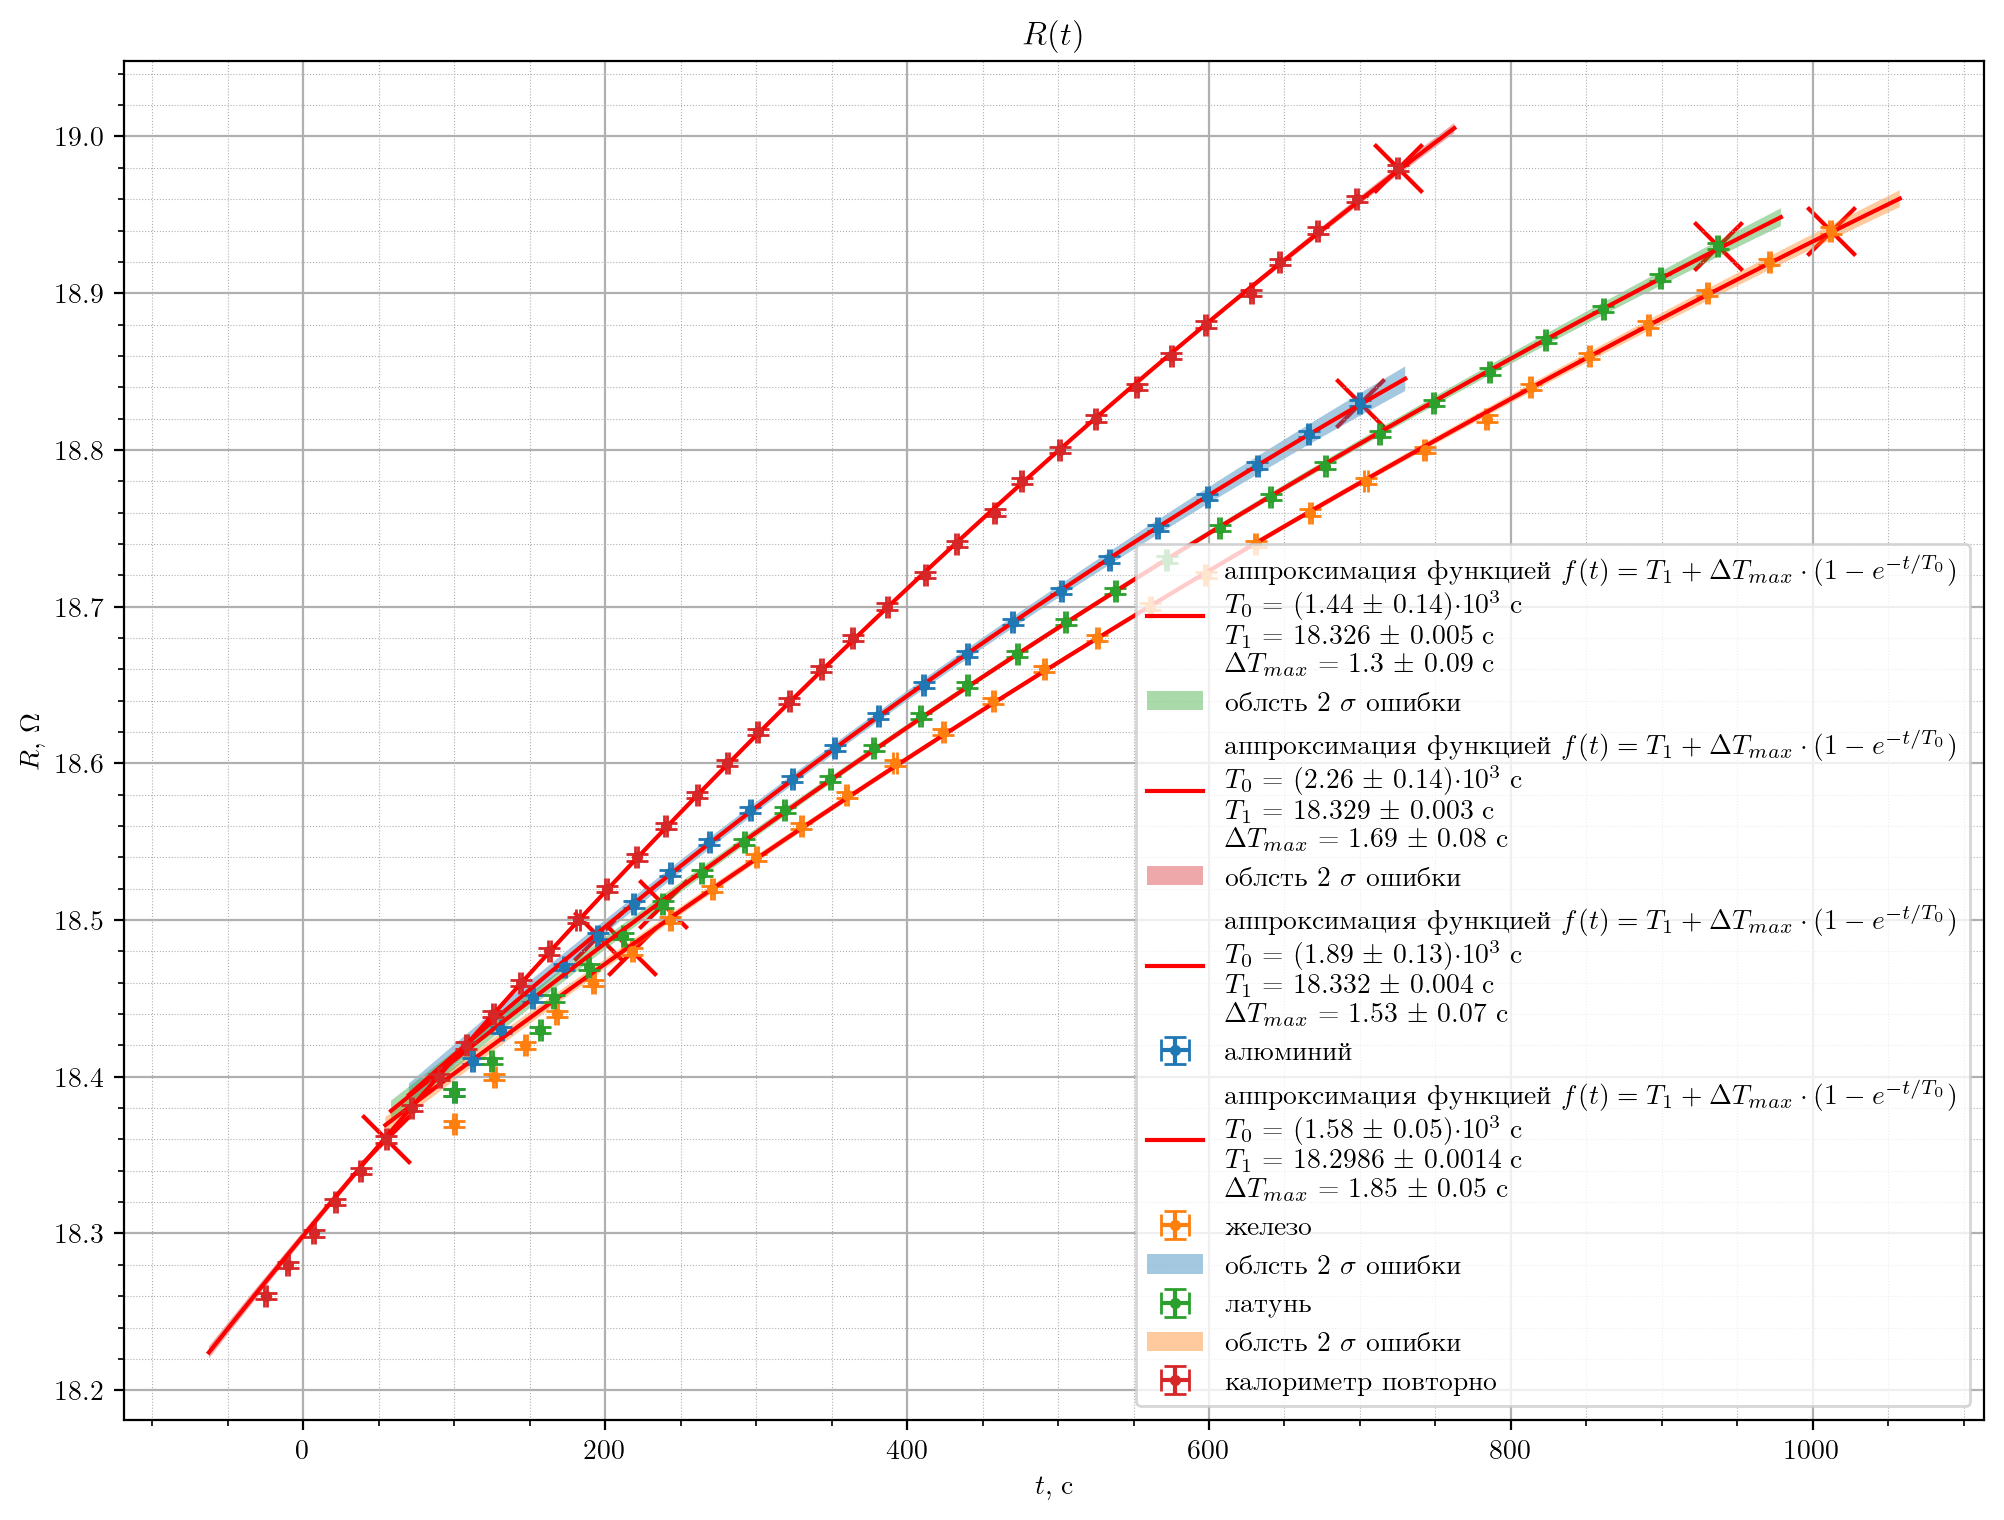

In [22]:
#Несколько графиков на одном холсте
df = pd.read_excel("measurements.ods", engine="odf")
def make_graph(N, xshift, begini=None, endi=None):
    size = 170
    x = df.iloc[:, 5*N+1].dropna()[:size] + xshift
    y = df.iloc[:, 5*N+0].dropna()[:size]
    label = df.iloc[:, 5*N+4].name
    xerr = np.ones_like(x)*1
    yerr = np.ones_like(x)*0.002

    popt, pcov = curve_fit(f, x[begini:endi], y[begini:endi], sigma=yerr[begini:endi], absolute_sigma=True, p0=[5000, 18.5, 300])
    if begini is not None:
        print(x[begini])
        plt.scatter(x[begini], y[begini], s=300, c='red', marker='x')
    else:
        plt.scatter(x[0], y[0], s=300, c='red', marker='x')
    if endi is not None:
        print(x[len(x) + endi-1])
        plt.scatter(x[len(x) + endi-1], y[len(x) + endi-1], s=300, c='red', marker='x')
    else:
        plt.scatter(x[len(x) + -1], y[len(x) + -1], s=300, c='red', marker='x')
    err = np.sqrt(np.diag(pcov))
    # for v, er in zip(popt, err):
    #     print(v,'+-',er)

    approx_label = f"аппроксимация функцией {fun_name}"
    par_names = [x.split(', ') for x in par_names_str.strip().split("\n")]
    for i in range(len(par_names)):
        name, units = par_names[i]
        approx_label += f"\n{name} = {err_pres_formatter(popt[i], err[i])} {units}"

    plt.errorbar(x, y, fmt="o", xerr=xerr, yerr=yerr, label=label, capsize=4, ms=3)
    teorPoints = 50     
    intent = 0.05   # отступ по бокам от обласи экспериментальных данных
    a, b = x.min(), x.max()
    X = np.linspace(a-(b-a)*intent, b+(b-a)*intent, num=teorPoints)

    def k(x, T_0, T_1, dT):
        return dT/T_0 + x - x
    mink, maxk = lower_upper_limits(X, k, popt, pcov, nsigma=2)
    print(k(0, *popt), "+-", (maxk[0]-mink[0])/2)

    plt.plot(X, f(X, *popt), 'r', label=approx_label)
    if visApproxError:
        nsigma = 2
        minA, maxA = lower_upper_limits(X, f, popt, pcov, nsigma=nsigma)
        plt.fill_between(X, minA, maxA, alpha=0.4, label=f"облсть {nsigma} $\sigma$ ошибки")

# make_graph(0)
make_graph(1, 100+0, begini=5)
make_graph(2, 100+0, begini=5)
make_graph(3, 100+0, begini=6)
make_graph(4, 100+-125, begini=5)

plt.grid(True, which='minor', linewidth=0.4, linestyle = ':')
plt.grid(True, which='major')
plt.xlabel(r"$t$, c")
plt.ylabel(r"$R$, $\Omega$")
plt.title(r"$R(t)$")

handles, labels = plt.gca().get_legend_handles_labels()
n = len(handles)//2
order = [i//2 if i%2==0 else n + i//2 for i in range(2*n)]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])

plt.savefig(f"{impath}{imNum}.png", dpi=300)
imNum+=1
# mymarker = plt.scatter(0.5, 0.9, s=300, c='red', transform=plt.gca().transAxes, marker='x', clip_on=False)
# mymarker = plt.scatter(0.5, 0.9, s=300, c='red', marker='x', clip_on=False)
# plt.gca().add_artist(mymarker)

In [10]:
def k(x, T_0, T_1, dT):
        dT/T_0

mink, maxk = lower_upper_limits(np.array([0, 0]), k, popt, pcov, nsigma=2)

NameError: name 'popt' is not defined